In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm.auto import tqdm
import xgboost as xgb
from catboost import CatBoostRegressor
from pprint import pprint
from sklearn.model_selection import KFold
from sklearn.base import clone

In [ ]:
df_train = pd.read_csv("regression-tabular-california-housing/train.csv", index_col=0, header=0)
df_train['RoomsPerPerson'] = df_train['AveRooms'] / df_train['AveOccup']
df_train['BedroomsPerRoom'] = df_train['AveBedrms'] / df_train['AveRooms']

bins = [0, 10, 30, np.inf]
labels = ['New', 'Mid-Age', 'Old']
df_train['AgeGroup'] = pd.cut(df_train['HouseAge'], bins=bins, labels=labels, right=False)
df_train = pd.get_dummies(df_train, columns=['AgeGroup'], drop_first=True)

CAP = df_train['MedHouseVal'].max()
FLOOR = df_train['MedHouseVal'].min()

In [ ]:
train_val_split = 0.2
random_state = 42

X = df_train.drop(columns=['MedHouseVal'])
y = df_train['MedHouseVal']

normalize_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'RoomsPerPerson', 'BedroomsPerRoom' ]


# normalize training data and store the mu and std
normalize_params = {col:{"mu":0.0, 'std':"0.0"} for col in normalize_cols}
for col in normalize_cols: 
    mu = X[col].mean()
    std = X[col].std(ddof=1)
    
    X[col] = (X[col] - mu)/std
    
    normalize_params[col]["mu"] = mu
    normalize_params[col]["std"] = std

X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=train_val_split, random_state=random_state)

# Categorical Boost

In [ ]:
param_grid_cb = {
    "iterations": [600, 1000, 1200],        # 1000 is best
    "depth": [6, 8, 10],                    # 8 is best
    "learning_rate": [0.03, 0.05, 0.1],     # 0.05 is best
    "l2_leaf_reg": [5, 8],                  # 5 is the best , trying 8
    "random_strength": [0.5, 1, 2]          # 1 is best
}

best_params_cb = None
best_score_cb = float('inf')

with tqdm(total=np.prod([len(v) for v in param_grid_cb.values()]), desc="CatBoost Grid Search Progress") as pbar:
    for iterations in param_grid_cb['iterations']:
        for depth in param_grid_cb['depth']:
            for learning_rate in param_grid_cb['learning_rate']:
                for l2_leaf_reg in param_grid_cb['l2_leaf_reg']:
                    for random_strength in param_grid_cb['random_strength']:
                        model = CatBoostRegressor(
                            iterations=iterations,
                            depth=depth,
                            learning_rate=learning_rate,
                            l2_leaf_reg=l2_leaf_reg,
                            random_strength=random_strength,
                            loss_function='RMSE',
                            random_seed=random_state,
                            thread_count=-1,
                            verbose=False,  # Set to True if you want to see training progress
                            early_stopping_rounds=50,  # Stop early if no improvement
                            bootstrap_type='Bayesian',  # Better than MVS for most cases
                            score_function='L2',        # For regression
                            leaf_estimation_method='Gradient'  # Better for regression
                        )
                        
                        model.fit(X_train, y_train, eval_set=(X_Val, y_Val), verbose=False)
                        
                        y_pred = model.predict(X_Val)
                        current_mse = mean_squared_error(y_Val, y_pred)

                        if current_mse < best_score_cb:
                            best_score_cb = current_mse
                            best_params_cb = {
                                'iterations': iterations,
                                'depth': depth,
                                'learning_rate': learning_rate,
                                'l2_leaf_reg': l2_leaf_reg,
                                'random_strength': random_strength
                            }
                        
                        pbar.update(1)

print("Best Parameters found for CatBoost: ", best_params_cb)
print(f"Best MSE: {best_score_cb:.5f}")

# Gradient Boost

In [ ]:
best_params_gb = None
param_grid_gb = {
    'n_estimators': [ 600, 900],            # Best is around 600
    'learning_rate': [0.01, 0.05],          # 0.05 is the best lr
    'max_depth': [5,7,9]                    # 6 is the best
}

best_params_gb = None
best_score_gb = float('inf')

with tqdm(total=np.prod( [len(val) for val in param_grid_gb.values()] ), desc="Gradient Boosting Grid Search Progress") as pbar_gb:
    for n_estimators in param_grid_gb['n_estimators']:
        for learning_rate in param_grid_gb['learning_rate']:
            for max_depth in param_grid_gb['max_depth']:
                model = GradientBoostingRegressor(n_estimators=n_estimators,
                                                  learning_rate=learning_rate,
                                                  max_depth=max_depth,
                                                  random_state=random_state)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_Val)
                current_mse = mean_squared_error(y_Val, y_pred)

                if current_mse < best_score_gb:
                    best_score_gb = current_mse
                    best_params_gb = {
                        'n_estimators': n_estimators,
                        'learning_rate': learning_rate,
                        'max_depth': max_depth
                    }
                
                pbar_gb.update(1)

print("Best Parameters found for Gradient Boosting: ", best_params_gb)
print(f"Best MSE: {best_score_gb:.5f}")


# XG Boost

In [ ]:
lambda_cap = 0.2
lambda_floor = 0

# def custom_objective(preds, dtrain):
#     y = dtrain.get_label()
#     p = preds.flatten().astype(np.float64)

#     # Base MSE grad/hess
#     grad = 2.0 * (p - y)
#     hess = np.full_like(p, 2.0, dtype=np.float64)

#     # Boolean masks
#     cap_mask = np.isclose(y, CAP)
#     floor_mask = np.isclose(y, FLOOR)

#     if np.any(cap_mask):
#         grad[cap_mask] += 2.0 * lambda_cap * (p[cap_mask] - CAP)
#         hess[cap_mask] += 2.0 * lambda_cap

#     if np.any(floor_mask):
#         grad[floor_mask] += 2.0 * lambda_floor * (p[floor_mask] - FLOOR)
#         hess[floor_mask] += 2.0 * lambda_floor
    
#     return grad, hess

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_Val, label=y_Val)

param_grid_xgb = {
    'n_estimators': [500, 700, 900],        #   best is 700
    'learning_rate': [0.01, 0.03, 0.05],    #   best is 0.03
    'max_depth': [5, 7, 10],                #   best is 7
    'subsample': [ 0.8,0.9,1.0],            #   best is 0.9
    'colsample_bytree': [0.8, 0.9,1.0],     #   best is 0.9
}

best_params_xgb = None
best_score_xgb = float('inf')

with tqdm(total= np.prod( [len(val) for val in param_grid_xgb.values()] ), desc="XGBoost Native API Grid Search Progress") as pbar_xgb:
    for n_estimators in param_grid_xgb['n_estimators']:
        for learning_rate in param_grid_xgb['learning_rate']:
            for max_depth in param_grid_xgb['max_depth']:
                for subsample in param_grid_xgb['subsample']:
                    for colsample_bytree in param_grid_xgb['colsample_bytree']:
                                                        
                            model = xgb.train(
                                params = {
                                'eval_metric': 'rmse',
                                'objective': 'reg:squarederror',
                                'eta': learning_rate,
                                'max_depth': max_depth,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree,
                                'seed': random_state,
                                'nthread': -1,
                                    },
                                dtrain=dtrain,
                                num_boost_round=n_estimators,
                                # obj=custom_objective,
                                 evals=[(dval, 'eval')],
                                early_stopping_rounds=50,
                                verbose_eval=False
                            )
                            
                            y_pred = model.predict(dval)
                            current_mse = mean_squared_error(y_Val, y_pred)

                            if current_mse < best_score_xgb:
                                best_score_xgb = current_mse
                                best_params_xgb = {
                                    'n_estimators': n_estimators,
                                    'learning_rate': learning_rate,
                                    'max_depth': max_depth,
                                    'subsample': subsample,
                                    'colsample_bytree': colsample_bytree,
                                }
                            
                            pbar_xgb.update(1)

print("Best Parameters found for XGBoost: ", best_params_xgb)
print(f"Best MSE from Grid Search: {best_score_xgb:.5f}")

# Ridge Regression

In [ ]:
param_grid_rr = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1.0],   # regularization strength (primary)
    "positive": [False, True],                     # optional: force non-negative coefficients
    "tol": [1e-4, 1e-3]                            # convergence tolerance (useful for iterative solvers)
}

best_params_rr = None
best_score_rr = float('inf')
total_combinations_rr = np.prod([len(v) for v in param_grid_rr.values()])

with tqdm(total=total_combinations_rr, desc="Ridge Regression Grid Search Progress") as pbar:
    for alpha in param_grid_rr["alpha"]:
        for positive in param_grid_rr["positive"]:
            for tol in param_grid_rr["tol"]:
                model = Ridge(
                    alpha=alpha,
                    positive=positive,
                    max_iter=10000,
                    random_state=random_state,
                    tol=tol  # Convergence tolerance
                )
                
                model.fit(X_train, y_train)
                
                y_pred = model.predict(X_Val)
                current_mse = mean_squared_error(y_Val, y_pred)

                if current_mse < best_score_rr:
                    best_score_rr = current_mse
                    best_params_rr = {
                        'alpha': alpha,
                        'positive': positive,
                        'tol': tol
                    }
                
                pbar.update(1)

print("Best Parameters found for Ridge Regression: ", best_params_rr)
print(f"Best MSE: {best_score_rr:.5f}")

# Stacking

In [150]:
""" Creating the Base Estimators """
estimators = []

# Generalists
# estimators.append( ('catb', CatBoostRegressor(**best_params_cb, 
#                                loss_function='RMSE',
#                             random_seed=random_state,
#                             thread_count=-1,
#                             verbose=False, 
#                             early_stopping_rounds=50,  
#                             bootstrap_type='Bayesian',  
#                             score_function='L2',        
#                             leaf_estimation_method='Gradient' )) )

# estimators.append( ('gb', GradientBoostingRegressor(**best_params_gb, random_state=random_state)) )
# estimators.append( ('xgb', xgb.XGBRegressor(**best_params_xgb, objective='reg:squarederror', random_state=random_state, n_jobs=1)) )
# estimators.append(  ('ridge', Ridge(**best_params_rr,  random_state=random_state)))

# Specialists
specialist_configs = [
    (0, 5, 50.0,  "lxgb"),     # bottom 5%
    (5, 30, 20.0, "lmxgb"),    # low-mid
    (30, 60, 10.0,"mxgb"),     # middle
    (60, 95, 20.0,"hmxgb"),    # high-mid
    (95, 100, 50.0,"uxgb")     # top 5%
]

# Init dict to store weights
specialists_weights = {}

# Dynamically create specialists
for low, high, w, suffix in specialist_configs:
    lower_thr = np.percentile(y_train, low)
    upper_thr = np.percentile(y_train, high)

    sw = np.ones_like(y_train, dtype=float)
    sw[(y_train >= lower_thr) & (y_train <= upper_thr)] = w

    # Specialist model
    spec_name = f"spec_{suffix}"
    spec_xgb = xgb.XGBRegressor(
        **best_params_xgb,
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=1
    )

    # Add to estimators and weights dict
    estimators.append((spec_name, spec_xgb))
    specialists_weights[spec_name] = sw

    print(f"{spec_name}: {low}-{high} percentile, "
          f"threshold=({lower_thr:.4f}, {upper_thr:.4f}), weight={w}")


""" Create the final Regressor """
final_regressor = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=random_state,
    n_jobs=-1,
    gamma = 0,
)


spec_lxgb: 0-5 percentile, threshold=(0.1500, 0.6620), weight=50.0
spec_lmxgb: 5-30 percentile, threshold=(0.6620, 1.3460), weight=20.0
spec_mxgb: 30-60 percentile, threshold=(1.3460, 2.1130), weight=10.0
spec_hmxgb: 60-95 percentile, threshold=(2.1130, 4.9592), weight=20.0
spec_uxgb: 95-100 percentile, threshold=(4.9592, 5.0000), weight=50.0


In [151]:
""" Do K-Fold Cross val to generate OOF (Out of Fold) Predictions and use that to train the final_regressor """
K = 5       # K fold
# Dictionary to store fitted base models
fitted_base_models = {}

kf = KFold(n_splits=K, shuffle=True, random_state=random_state)
oof_preds = np.zeros((len(X_train), len(estimators)))

for i, (name, est) in enumerate(estimators):
    print(f"Regressor: {name}")
    oof_col = np.zeros(len(X_train))
    
    sample_weights = specialists_weights[name] if (name in specialists_weights.keys()) else  np.ones_like(y_train)
    for j, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        
        est_clone = clone(est)
        est_clone.fit(X_train.iloc[train_idx], y_train.iloc[train_idx], sample_weight=sample_weights[train_idx])
        oof_col[val_idx] = est_clone.predict(X_train.iloc[val_idx])
        
        print(f"Fold: {j+1} completed")
    oof_preds[:, i] = oof_col

final_regressor.fit(oof_preds, y_train)
print(f"Final Regressor trained")

""" Fit Base Models on the exntire Train Set """
for name, est in estimators:
    est_clone = clone(est)             # clone to avoid overwriting
    sample_weights = specialists_weights[name] if (name in specialists_weights.keys()) else  np.ones_like(y_train)
    est_clone.fit(X_train, y_train, sample_weight=sample_weights)  # fit on full training data
    fitted_base_models[name] = est_clone  # store the fitted model
    print(f"Base Regressor {name} trained")
    
 

Regressor: spec_lxgb
Fold: 1 completed
Fold: 2 completed
Fold: 3 completed
Fold: 4 completed
Fold: 5 completed
Regressor: spec_lmxgb
Fold: 1 completed
Fold: 2 completed
Fold: 3 completed
Fold: 4 completed
Fold: 5 completed
Regressor: spec_mxgb
Fold: 1 completed
Fold: 2 completed
Fold: 3 completed
Fold: 4 completed
Fold: 5 completed
Regressor: spec_hmxgb
Fold: 1 completed
Fold: 2 completed
Fold: 3 completed
Fold: 4 completed
Fold: 5 completed
Regressor: spec_uxgb
Fold: 1 completed
Fold: 2 completed
Fold: 3 completed
Fold: 4 completed
Fold: 5 completed
Final Regressor trained
Base Regressor spec_lxgb trained
Base Regressor spec_lmxgb trained
Base Regressor spec_mxgb trained
Base Regressor spec_hmxgb trained
Base Regressor spec_uxgb trained


Mean Squared Error (MSE): 0.35404


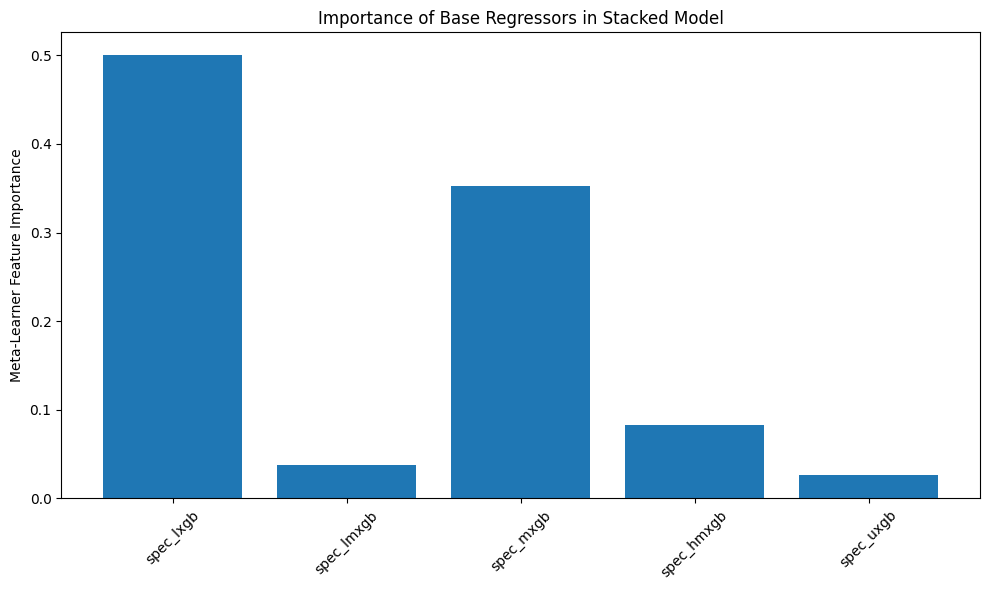

spec_lxgb: 0.5009
spec_lmxgb: 0.0380
spec_mxgb: 0.3523
spec_hmxgb: 0.0825
spec_uxgb: 0.0262


In [152]:
   
""" Predict using the Entire Stack on validation """
# Generate Predictions from the base models
base_reg_preds = np.zeros((len(X_Val), len(estimators)))
for i, name in enumerate(fitted_base_models):
    base_reg_preds[:, i] = fitted_base_models[name].predict(X_Val)

# use the base regression values for the final regressor
y_pred_stack = final_regressor.predict(base_reg_preds)
mse_stack = mean_squared_error(y_Val, y_pred_stack)
print(f"Mean Squared Error (MSE): {mse_stack:.5f}")

""" Plot Importances """
base_names = [name for name, _ in estimators]
importances = final_regressor.feature_importances_

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(base_names, importances)
plt.ylabel("Meta-Learner Feature Importance")
plt.title("Importance of Base Regressors in Stacked Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, imp in zip(base_names, importances):
    print(f"{name}: {imp:.4f}")

# Prediction on Test Data

In [153]:
df_test = pd.read_csv("regression-tabular-california-housing/test.csv", index_col=0, header=0)

df_test['RoomsPerPerson'] = df_test['AveRooms'] / df_test['AveOccup']
df_test['BedroomsPerRoom'] = df_test['AveBedrms'] / df_test['AveRooms']
bins = [0, 10, 30, np.inf]
labels = ['New', 'Mid-Age', 'Old']
df_test['AgeGroup'] = pd.cut(df_test['HouseAge'], bins=bins, labels=labels, right=False)
df_test = pd.get_dummies(df_test, columns=['AgeGroup'], drop_first=True)

# normalize Test data
for col in normalize_cols: 
    mu = normalize_params[col]["mu"]
    std = normalize_params[col]["std"]
    df_test[col] = (df_test[col] - mu)/std

' Histogram of base regressors vs ground truth '

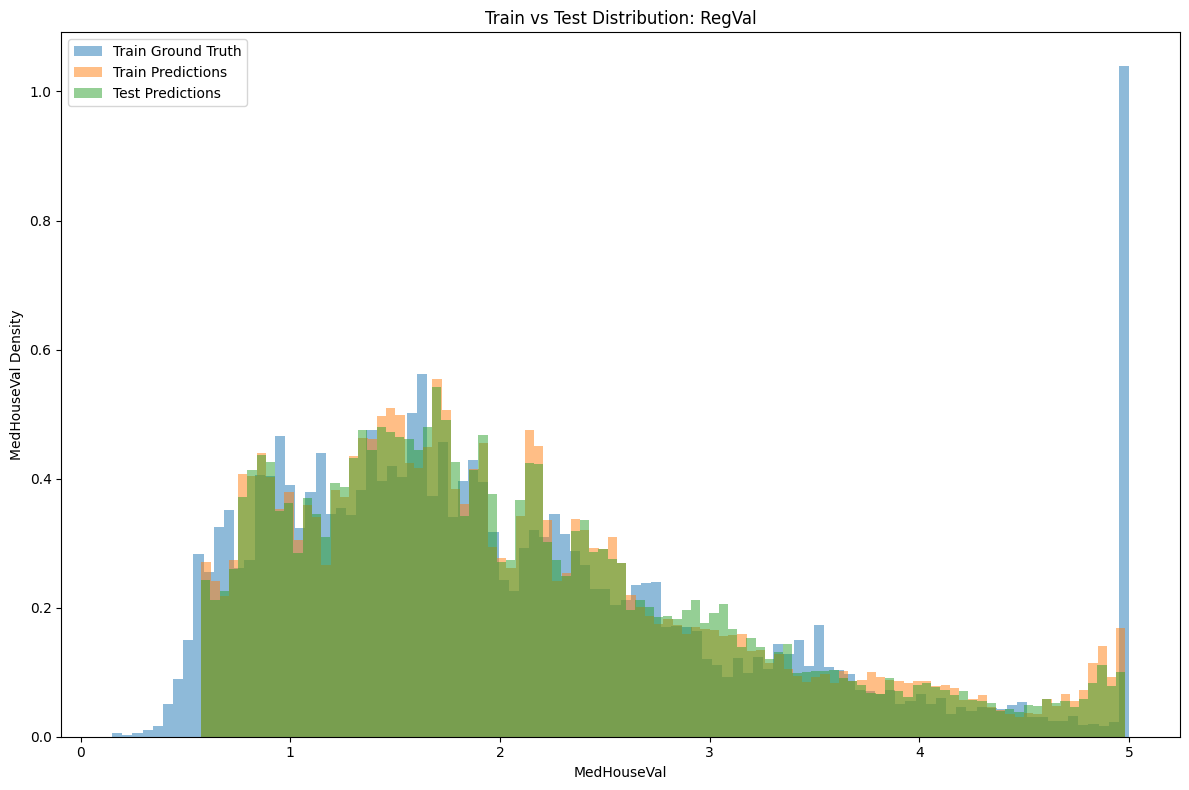

In [ ]:
""" Histogram the train_ground_truth, train_pred, and test_pred for the overall model """
# Prediction on Train Set
train_base_preds = np.zeros((len(X_train), len(fitted_base_models)))
for i, name in enumerate(fitted_base_models):
    train_base_preds[:, i] = fitted_base_models[name].predict(X_train)
train_pred = final_regressor.predict(train_base_preds)

# Predictions are Clipped
train_pred = np.clip(train_pred, a_min=FLOOR, a_max=CAP)

# Prediction on test set
test_base_preds = np.zeros((len(df_test), len(fitted_base_models)))
for i, name in enumerate(fitted_base_models):
    test_base_preds[:, i] = fitted_base_models[name].predict(df_test)
test_pred = final_regressor.predict(test_base_preds)

# Predictions are Clipped
test_pred = np.clip(test_pred, a_min=FLOOR, a_max=CAP)

bins = 100
plt.figure(figsize=(12, 8))
plt.hist(y_train, bins=bins, alpha=0.5, label="Train Ground Truth", density=True)
plt.hist(train_pred, bins=bins, alpha=0.5, label="Train Predictions", density=True)
plt.hist(test_pred, bins=bins, alpha=0.5, label="Test Predictions", density=True)
plt.title(f"Train vs Test Distribution: RegVal")
plt.xlabel("MedHouseVal")
plt.ylabel(f"MedHouseVal Density")
plt.legend()
plt.tight_layout()


""" Histogram of base regressors vs ground truth """
# plt.figure(figsize=(12, 8))

# # ground truth
# plt.hist(y_train, bins=bins, alpha=0.5, label="Train Ground Truth", density=True)

# # loop over base estimators
# for name, model in estimators:
#     if name not in specialists_weights.keys():continue
#     y_pred = model.fit(X_train, y_train).predict(X_train)   # fit on full training data
#     y_pred = np.clip(y_pred, FLOOR, CAP)                   # apply clipping
#     plt.hist(y_pred, bins=100, alpha=0.5, label=f"{name} Predictions", density=True)

# plt.title("Base Regressors vs Ground Truth on Training Data")
# plt.xlabel("MedHouseVal")
# plt.ylabel("Density")
# plt.legend()
# plt.tight_layout()
# plt.show()

# Residuals Plot

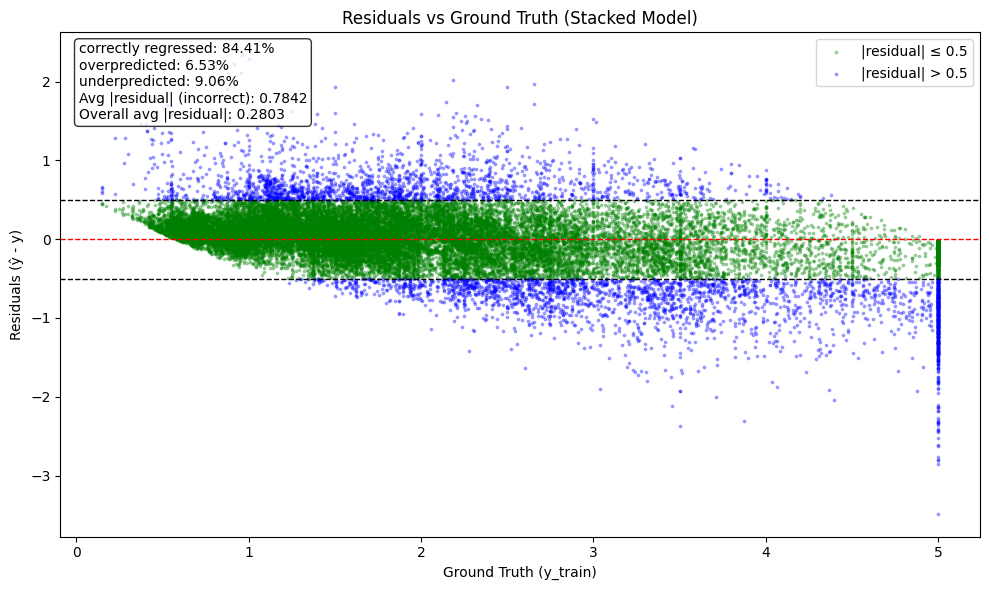

In [155]:
epsilon = 0.5

residuals = train_pred - y_train

plt.figure(figsize=(10, 6))

# mask for points within ±epsilon
within_mask = np.abs(residuals) <= epsilon
outside_mask = ~within_mask

# plot within-band points in green
plt.scatter(y_train[within_mask], residuals[within_mask], 
            alpha=0.3, s=3, c="green", label=f"|residual| ≤ {epsilon}")

# plot outside-band points in blue
plt.scatter(y_train[outside_mask], residuals[outside_mask], 
            alpha=0.3, s=3, c="blue", label=f"|residual| > {epsilon}")

# horizontal reference lines
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.axhline(epsilon, color="black", linestyle="--", linewidth=1)
plt.axhline(-epsilon, color="black", linestyle="--", linewidth=1)

plt.xlabel("Ground Truth (y_train)")
plt.ylabel("Residuals (ŷ - y)")
plt.title("Residuals vs Ground Truth (Stacked Model)")
plt.legend()

# ---- stats ----
pct_correct = 100 * np.mean(within_mask)
pct_over = 100 * np.mean(residuals > epsilon)
pct_under = 100 * np.mean(residuals < -epsilon)
avg_abs_resid_incorrect = np.mean(np.abs(residuals[outside_mask])) if np.any(outside_mask) else 0.0
overall_abs_resid = np.mean(np.abs(residuals))

# stats text
stats_text = (
    f"correctly regressed: {pct_correct:.2f}%\n"
    f"overpredicted: {pct_over:.2f}%\n"
    f"underpredicted: {pct_under:.2f}%\n"
    f"Avg |residual| (incorrect): {avg_abs_resid_incorrect:.4f}\n"
    f"Overall avg |residual|: {overall_abs_resid:.4f}"
)

# add textbox to plot
plt.gca().text(
    0.02, 0.98, stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# Submission File

In [159]:
"""Creating the submission file"""
submission = pd.DataFrame({ "id": df_test.index, "MedHouseVal": test_pred })
submission.to_csv("submission.csv", index=False)
